Data Cleaning
====
First we want to check the feasibility of using these smartwatches in this population, but even before we can do that we need to clean the data

### Pre-trial Entries
Some of the entries were made before the start of the study proper.

### Duplicates
Some entries were recorded twice by the smartwatches; either as user error or a fault with the watch.


In [1]:
"""
Preamble

"""
%load_ext autoreload
%autoreload 2

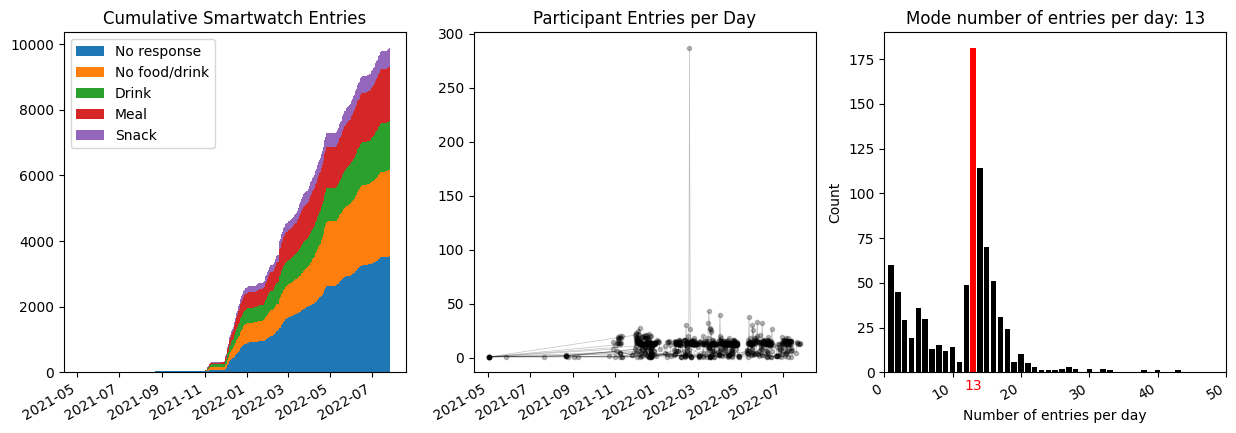

In [2]:
"""
Show the visualisations that we'll be using to clean the data

"""
import matplotlib.pyplot as plt
from ema import read, plotting, clean


def three_plots(path: str):
    """
    Make three plots from meal_info

    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    plotting.entry_time_hist(meal_info, cumulative=True, fig_ax=(fig, axes[0]))
    axes[0].set_title("Cumulative Smartwatch Entries")

    plotting.participant_entries_per_day(meal_info, fig_ax=(fig, axes[1]))
    axes[1].set_title("Participant Entries per Day")

    *_, mode = plotting.participant_entries_histogram(meal_info, fig_ax=(fig, axes[2]))
    axes[2].set_title(f"Mode number of entries per day: {mode}")

    fig.autofmt_xdate()
    fig.savefig(path)


meal_info = read.all_meal_info()
meal_info = meal_info[~clean.catchups_mask(meal_info)]
three_plots("img/before_cleaning.png")

Things to note:
- There's a long tail on the left histogram; there are a few entries way before the rest of them
- We can also see this in the middle plot
- There's also one participant entering loads of entries on the same day - we can see this in the middle plot
- There's quite a lot of days with not many entries (right plot, left of the red bar)

First we'll get rid of entries before the start of the trial
### Pre-trial Entries

1757 early entries removed of 9871


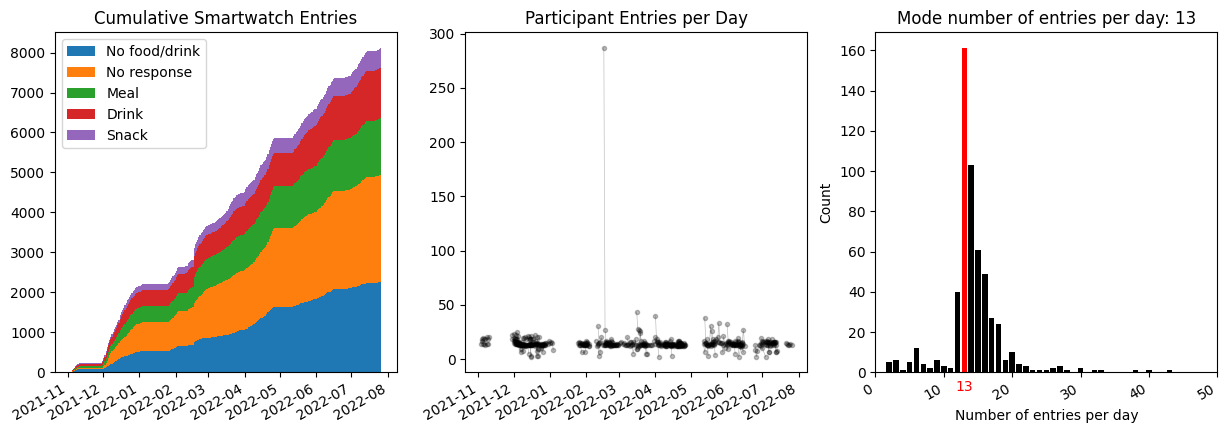

In [3]:
"""
Remove entries before the start of the trial, and also day 1 since this is incomplete

"""
import pandas as pd
import numpy as np


def remove_early_entries(meal_df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove entries before the start of the trial, and also day 1 since this is incomplete

    Prints how many were removed

    """
    # Find watch collection dates for each participant
    feasibility_info = read.smartwatch_feasibility()

    # We only care about ones who consented to the smartwatch study
    feasibility_info = feasibility_info[feasibility_info["smartwatchwilling"] == 1]
    feasibility_info = feasibility_info[["residents_id", "actualdateofdistribution1st"]]

    # Join dataframes
    meal_df = (
        meal_df.reset_index()
        .merge(feasibility_info, left_on="p_id", right_on="residents_id", how="left")
        .set_index(meal_df.index)
    )

    assert (
        meal_df["actualdateofdistribution1st"].isna().sum() == 0
    ), "Missing distribution dates"

    # Remove entries before the collection date
    meal_df["delta"] = (
        meal_df.index.to_series() - meal_df["actualdateofdistribution1st"]
    )
    keep = meal_df["delta"].dt.days >= 1
    print(f"{np.sum(~keep)} early entries removed of {len(meal_df)}")

    return meal_df[keep]


meal_info = remove_early_entries(meal_info)

three_plots("img/removed_pre_trial.png")

Now:
- The long tail has disappeared
- The big spike is still there in the middle plot
- There are now fewer days with only a few entries

### Why remove entries on the first day of the study?
We think that this isn't a valid day (it will follow a different pattern to the other days), because it looks like there are far fewer events on the first day of the study

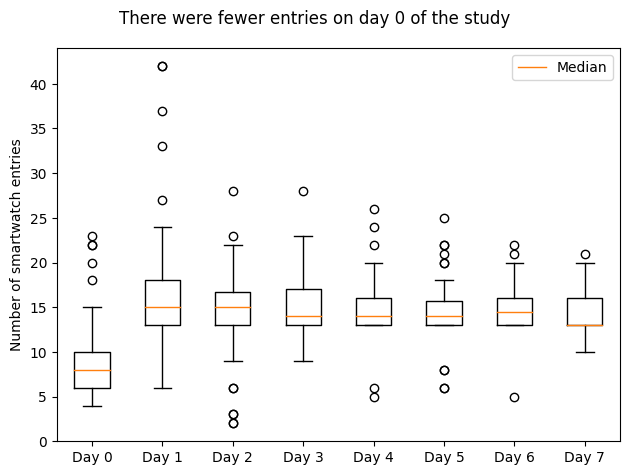

In [4]:
"""
Stacked histogram of entries by entry date

"""
# Re read to get a clean slate
meal_info = read.all_meal_info()

# Remove duplicates. See the below cell for more, probably
meal_info = meal_info[~clean.duplicates(meal_info)]

# Add a delta column for the days after distribution
meal_info = read.add_timedelta(meal_info)


def boxplot(meal_df: pd.DataFrame, path: str, *, title: str = None):
    """
    Make a boxplot of the number of entries per day and save it

    Optionally specify a title

    """
    fig, axis = plt.subplots()
    occurrences_per_day = []
    for day in range(8):
        # Find entries on this day
        mask = (meal_df["delta"] > pd.Timedelta(days=day)) & (
            meal_df["delta"] < pd.Timedelta(days=day + 1)
        )
        df_slice = meal_df[mask]

        # Find how many entries each participant has
        _, occurrences = np.unique(df_slice["p_id"], return_counts=True)
        occurrences_per_day.append(occurrences)

    boxes = axis.boxplot(occurrences_per_day, showmeans=False)

    axis.set_xticks(range(1, 9), [f"Day {day}" for day in range(8)])
    axis.set_ylabel("Number of smartwatch entries")
    axis.legend(boxes["medians"], ["Median"])

    fig.suptitle(
        "There were fewer entries on day 0 of the study" if title is None else title
    )

    fig.tight_layout()
    fig.savefig(path)


boxplot(meal_info, "img/n_entries_per_day_boxplot.png")

In [5]:
"""
We can also do this showing only/exluding the No Responses

"""
# Commented these out to save plot space
# boxplot(
#     meal_info[meal_info["meal_type"] == "No response"],
#     "img/n_noresponses_per_day_boxplot.png",
#     title="No Responses per day",
# )
# boxplot(
#     meal_info[meal_info["meal_type"] != "No response"],
#     "img/n_responses_per_day_boxplot.png",
#     title="Excluding No Responses",
# )

'\nWe can also do this showing only/exluding the No Responses\n\n'

found 572 duplicates of 10539 entries
2074 early entries removed of 10539


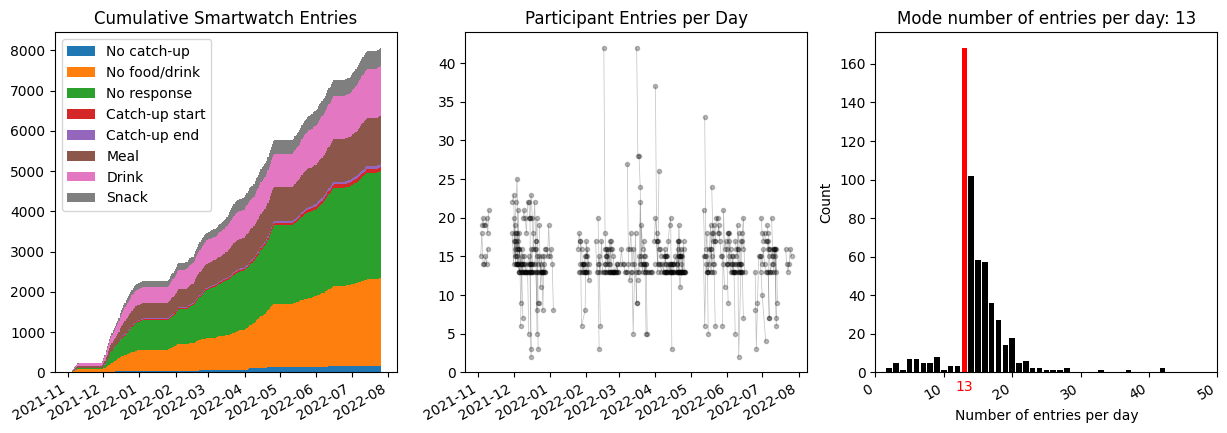

In [6]:
"""
Let's also remove duplicates

"""

# Re read to get a clean slate
meal_info = read.all_meal_info()

duplicates = clean.duplicates(meal_info)
print(f"found {duplicates.sum()} duplicates of {len(meal_info)} entries")
meal_info = meal_info.loc[~duplicates]

# Let's do both
# TODO it looks like the order matters here, but it shouldn't; need to figure out why
meal_info = remove_early_entries(read.all_meal_info())
meal_info = meal_info[~clean.duplicates(meal_info)]

three_plots("img/removed_duplicates.png")

Things to note:
- The big spike in the middle plot has gone away
- Some of the events with more entries in the right hand plot have gone away

Let's also check that we get the same result (that the graphs look the same) when we use the data cleaning library function:

plots are the same ✅


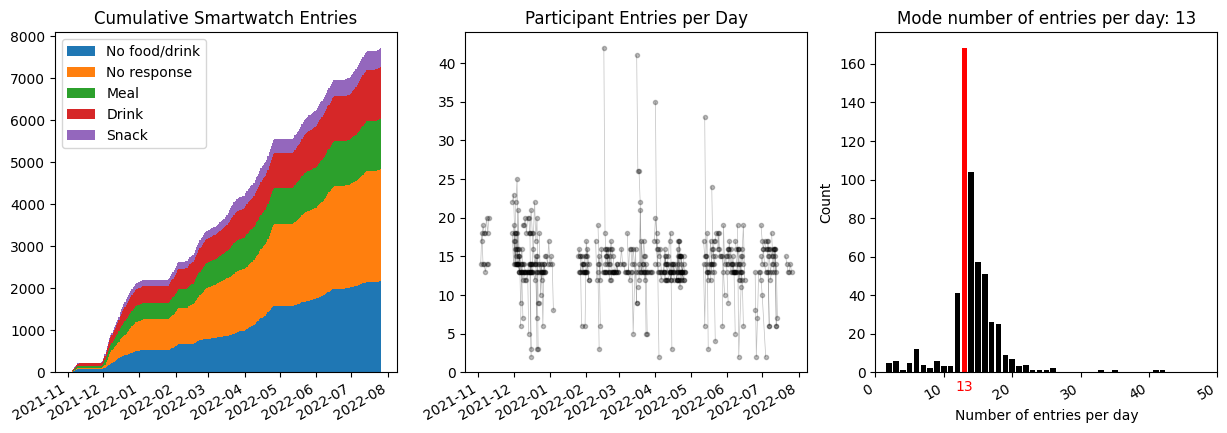

In [7]:
"""
Use my cleaning function to do all the above, and check the plot output is the same

"""
import os

meal_info = clean.cleaned_smartwatch(remove_catchups=True)

tmp_path = "tmp.png"
try:
    three_plots(tmp_path)
    assert (
        open(tmp_path, "rb").read() == open("img/removed_catchup.png", "rb").read()
    )
    print("plots are the same \u2705")
    os.remove(tmp_path)

except AssertionError:
    print("plots are not the same \u274C")

The plots should be the same;

TODO they might not be since my cleaning steps seem to be order-dependent - need to find out why this is